## Relax Challenge

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample

In [2]:
#open files
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement_df = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')

print(users_df.head(5))
print(engagement_df.head(5))

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [3]:
# missing values
missing_values_users = users_df.isnull().sum()
missing_values_engagement = engagement_df.isnull().sum()

missing_values_users, missing_values_engagement

(object_id                        0
 creation_time                    0
 name                             0
 email                            0
 creation_source                  0
 last_session_creation_time    3177
 opted_in_to_mailing_list         0
 enabled_for_marketing_drip       0
 org_id                           0
 invited_by_user_id            5583
 dtype: int64,
 time_stamp    0
 user_id       0
 visited       0
 dtype: int64)

In [4]:
# nan in last_session_creation_time: the user did not use the account since creation
# replace it by creation time
users_df['last_session_creation_time'].fillna(users_df['creation_time'], inplace=True)

# nan for invited_by_user_id: the user was not invited by another
# replace it by zero
users_df['invited_by_user_id'].fillna(0, inplace=True)

# missing values
missing_values_users = users_df.isnull().sum()
missing_values_users

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

In [5]:
#check type
print(users_df.dtypes)
print(engagement_df.dtypes)

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time     object
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object
time_stamp    object
user_id        int64
visited        int64
dtype: object


In [6]:
# convert to datetime
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])

engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])
engagement_df.set_index('time_stamp', inplace=True)
engagement_df.sort_index(inplace=True)


print(users_df.dtypes)
print(engagement_df.dtypes)

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object
user_id    int64
visited    int64
dtype: object


In [7]:
# find adopted users
def label_adopted_users(user_df):
    adopted = False
    daily_engagement = user_df['visited'].resample('D').sum()
    adopted = daily_engagement.rolling(window=7).sum().max() >= 3
    return adopted

adopted_users = engagement_df.groupby('user_id').apply(label_adopted_users).reset_index()
adopted_users.rename(columns={0: 'adopted_user'}, inplace=True)

In [8]:
# merge:  adopted users & users dfs
merged_df = users_df.merge(adopted_users, left_on='object_id', right_on='user_id', how='left')

# not adopted = False 
merged_df['adopted_user'].fillna(False, inplace=True)
merged_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0,1.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,2.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0,3.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0,4.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0,5.0,False


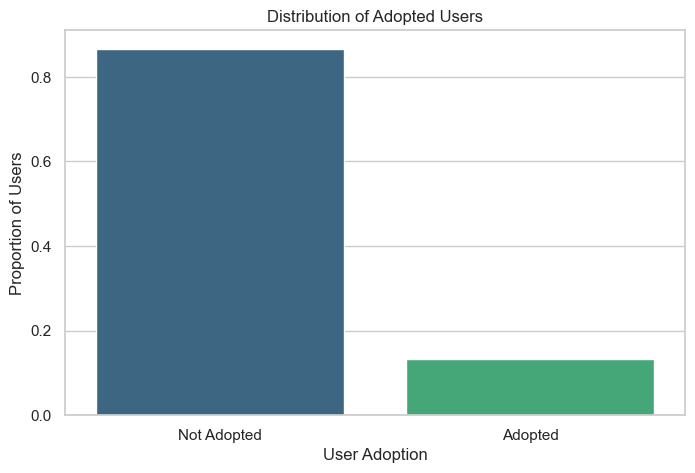

False    0.866917
True     0.133083
Name: adopted_user, dtype: float64

In [9]:
sns.set(style="whitegrid")

# distribution of adopted_user 
adopted_distribution = merged_df['adopted_user'].value_counts(normalize=True)

# bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=adopted_distribution.index, y=adopted_distribution.values, palette='viridis')
plt.title('Distribution of Adopted Users')
plt.xlabel('User Adoption')
plt.ylabel('Proportion of Users')
plt.xticks([0, 1], ['Not Adopted', 'Adopted'])
plt.show()

adopted_distribution

* About 13% of the users have logged into the product on 3 days within at least 7-day period.
* Approximately 87% user did not.

<Figure size 1000x600 with 0 Axes>

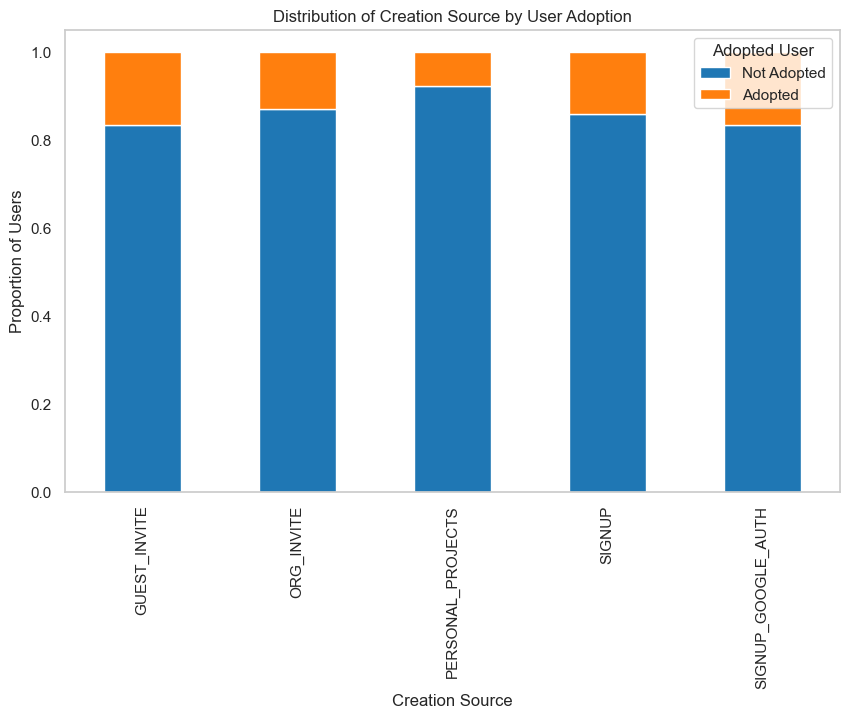

adopted_user,False,True
creation_source,,
GUEST_INVITE,0.83,0.17
ORG_INVITE,0.87,0.13
PERSONAL_PROJECTS,0.92,0.08
SIGNUP,0.86,0.14
SIGNUP_GOOGLE_AUTH,0.83,0.17


In [10]:
# CREATION SOURCE
# normalize distribution
creation_source_dist = pd.crosstab(merged_df['creation_source'], merged_df['adopted_user'])
creation_source_dist_pct = creation_source_dist.div(creation_source_dist.sum(1), axis=0)

plt.figure(figsize=(10, 6))
creation_source_dist_pct.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], grid=False, figsize=(10, 6))
plt.title('Distribution of Creation Source by User Adoption')
plt.xlabel('Creation Source')
plt.ylabel('Proportion of Users')
plt.legend(title='Adopted User', labels=['Not Adopted', 'Adopted'])
plt.show()

creation_source_dist_pct.round(2)

Based on the creation source, these are the percentages for users who have logged into the product on 3 days within at least 7-day period:
* GUEST_INVITE: 17%
* ORG_INVITE: 13% 
* PERSONAL_PROJECTS: 8% 
* SIGNUP: 14% a
* SIGNUP_GOOGLE_AUTH: 17% 

**Users who were invited to join as a guest (GUEST_INVITE) or who signed up using Google Authentication (SIGNUP_GOOGLE_AUTH) have a slightly higher proportion of adoption compared to other sources.**

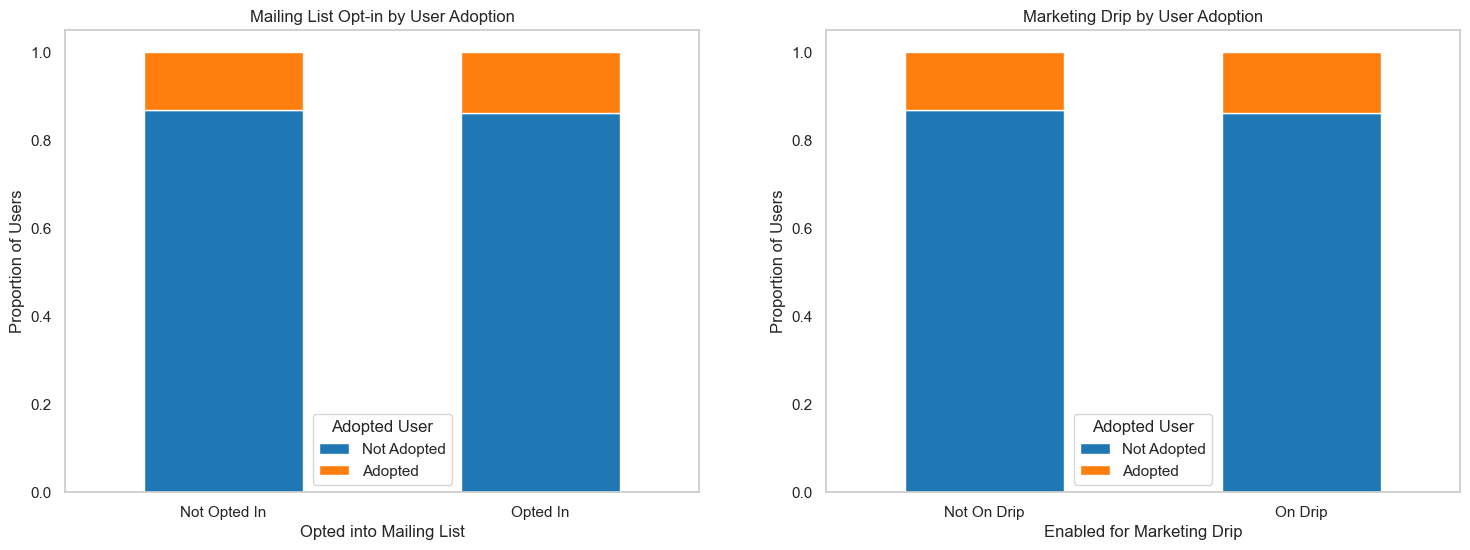

(adopted_user              False  True 
 opted_in_to_mailing_list              
 0                          0.87   0.13
 1                          0.86   0.14,
 adopted_user                False  True 
 enabled_for_marketing_drip              
 0                            0.87   0.13
 1                            0.86   0.14)

In [11]:
# MAILING LIST & MARKETING DRIP

# normalize distribution: mailing list
mailing_list_adoption = pd.crosstab(merged_df['opted_in_to_mailing_list'], merged_df['adopted_user'])
mailing_list_adoption_pct = mailing_list_adoption.div(mailing_list_adoption.sum(1), axis=0)

# normalize distribution: marketing drip 
marketing_drip_adoption = pd.crosstab(merged_df['enabled_for_marketing_drip'], merged_df['adopted_user'])
marketing_drip_adoption_pct = marketing_drip_adoption.div(marketing_drip_adoption.sum(1), axis=0)


fig, ax = plt.subplots(1, 2, figsize=(18, 6))
mailing_list_adoption_pct.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], grid=False, ax=ax[0])
ax[0].set_title('Mailing List Opt-in by User Adoption')
ax[0].set_xlabel('Opted into Mailing List')
ax[0].set_ylabel('Proportion of Users')
ax[0].set_xticklabels(['Not Opted In', 'Opted In'], rotation=0)
ax[0].legend(title='Adopted User', labels=['Not Adopted', 'Adopted'])

marketing_drip_adoption_pct.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], grid=False, ax=ax[1])
ax[1].set_title('Marketing Drip by User Adoption')
ax[1].set_xlabel('Enabled for Marketing Drip')
ax[1].set_ylabel('Proportion of Users')
ax[1].set_xticklabels(['Not On Drip', 'On Drip'], rotation=0)
ax[1].legend(title='Adopted User', labels=['Not Adopted', 'Adopted'])
plt.show()

(mailing_list_adoption_pct.round(2), marketing_drip_adoption_pct.round(2))

Based on the users who have opted into the mailing list and those who are on the marketing email drip, these are the percentages for the ones who have logged into the product on 3 days within at least 7-day period:

* 13% of users who have not opted into the mailing list
* 14% of users who have opted into the mailing list
* 13% of users who are not enrolled in the marketing drip
* 14% of users who are enrolled in the marketing drip

**The data indicates that the proportions of adopted users are almost identical across both categories, suggesting that opting into the mailing list or being on the marketing drip are not significantly predictive of user adoption rates.**

/var/folders/tn/_cldsrsx169d6c6_fzk5x91h0000gn/T/ipykernel_5961/2017993102.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(org_adoption, bins=30, kde=False)


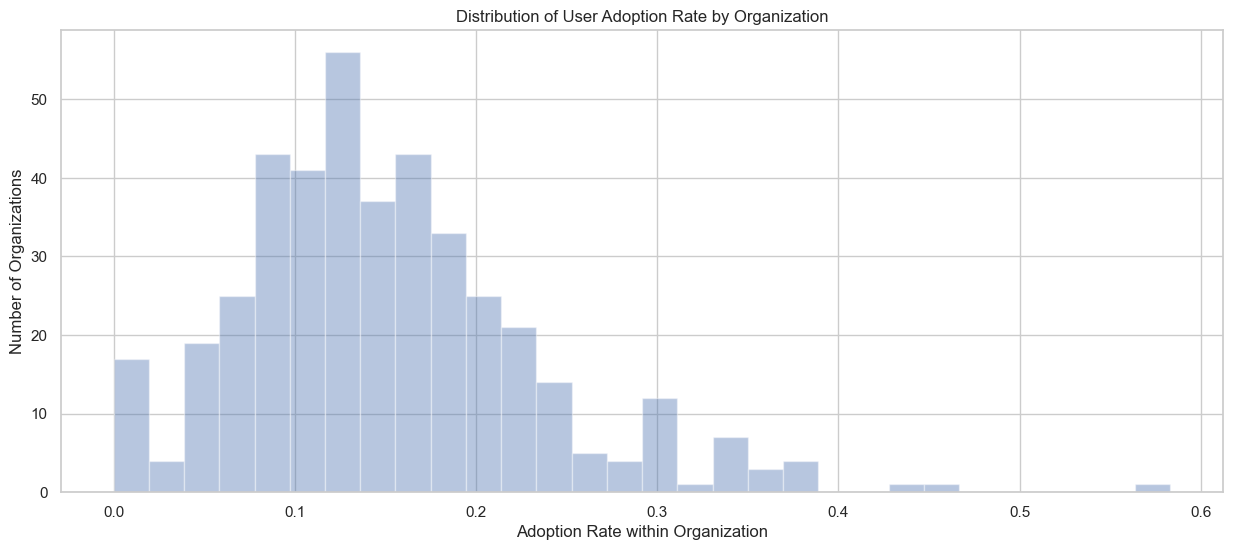

count    417.000000
mean       0.149440
std        0.081998
min        0.000000
25%        0.095238
50%        0.137931
75%        0.190476
max        0.583333
Name: adopted_user, dtype: float64

In [12]:
# ORGANIZATION ID
org_adoption = merged_df.groupby('org_id')['adopted_user'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
sns.distplot(org_adoption, bins=30, kde=False)
plt.title('Distribution of User Adoption Rate by Organization')
plt.xlabel('Adoption Rate within Organization')
plt.ylabel('Number of Organizations')
plt.show()

org_adoption.describe()

The distribution of user adoption rates by organization shows that there is some variation among organizations, with the mean adoption rate being about 14.94% and a wide range of adoption rates, from 0% to as high as 58.33% in some organizations.

---

In [13]:
## FEATURE ENGINEERING

# 'creation_source': one-hot encode
encoder = OneHotEncoder(sparse=False)
creation_source_encoded = encoder.fit_transform(merged_df[['creation_source']])
creation_source_df = pd.DataFrame(creation_source_encoded, 
                                  columns=encoder.get_feature_names_out(['creation_source']))

# new df: original df + one-hot encoded df dataframe
merged_encoded_df = pd.concat([merged_df, creation_source_df], axis=1)

/Applications/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
## RANDOM FOREST MODEL

# feature
X = merged_encoded_df[encoder.get_feature_names_out(['creation_source'])].join(merged_encoded_df['org_id'])
# target
y = merged_encoded_df['adopted_user']

# split df: training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random forest classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

print(f'Accuracy:', accuracy)
print(f'Classification report:\n', classification_report_output)

Accuracy: 0.8386111111111111
Classification report:
               precision    recall  f1-score   support

       False       0.87      0.96      0.91      3116
        True       0.22      0.08      0.11       484

    accuracy                           0.84      3600
   macro avg       0.54      0.52      0.51      3600
weighted avg       0.78      0.84      0.80      3600



The Random Forest model has an overall accuracy of 83.86% in predicting "adopted users," but this figure is potentially misleading due to class imbalance. It performs well in identifying non-adopted users, with a precision of 0.87 and recall of 0.96, resulting in a solid F1-score of 0.91 for this class. However, it struggles with the adopted user class, showing a low precision of 0.22 and recall of 0.08, culminating in a poor F1-score of 0.11. This discrepancy highlights the model's difficulty in detecting the rarer adopted users, emphasizing the need for further refinement and consideration of class imbalance in the modeling process.

Given the significant disparity in class distribution, with 3,116 instances of non-adopted users compared to just 484 instances of adopted users, it's crucial to address this class imbalance to improve our model's predictive accuracy. One effective method for achieving a more balanced class representation is upsampling the minority class within our dataset. By doing so, we can enhance the model's ability to learn from the underrepresented class and, consequently, make more reliable predictions

In [22]:
# Separate majority and minority classes
df_majority = merged_encoded_df[merged_encoded_df['adopted_user'] == False]
df_minority = merged_encoded_df[merged_encoded_df['adopted_user'] == True]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,                    
                                 n_samples=len(df_majority),      
                                 random_state=42)                

# Combine majority class with upsampled minority class
upsampled_df = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the dataframe to prevent any ordering effects
upsampled_df = upsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [24]:
# Reset index
upsampled_df.reset_index(drop=True, inplace=True)

# new feature and target
X_upsampled = upsampled_df[encoder.get_feature_names_out(['creation_source'])].join(upsampled_df['org_id'].reset_index(drop=True))
y_upsampled = upsampled_df['adopted_user'].reset_index(drop=True)

# new training and test
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(
    X_upsampled, y_upsampled, test_size=0.3, random_state=42)

# Retrain the model with the upsampled data
rf_clf_upsampled = RandomForestClassifier(random_state=42)
rf_clf_upsampled.fit(X_train_upsampled, y_train_upsampled)

# Predict on the upsampled test set
y_pred_upsampled = rf_clf_upsampled.predict(X_test_upsampled)

# model eval
accuracy_upsampled = accuracy_score(y_test_upsampled, y_pred_upsampled)
classification_report_upsampled_output = classification_report(y_test_upsampled, y_pred_upsampled)

# pri|nt(upsampled_counts)
print(f'Accuracy:', accuracy_upsampled)
print(f'Classification report:\n', classification_report_upsampled_output)

Accuracy: 0.712431912848446
Classification report:
               precision    recall  f1-score   support

       False       0.75      0.64      0.69      3134
        True       0.68      0.79      0.73      3108

    accuracy                           0.71      6242
   macro avg       0.72      0.71      0.71      6242
weighted avg       0.72      0.71      0.71      6242



After adjusting for imbalanced data through upsampling, the accuracy of our Random Forest model went down from about 84% to 71%. But the model got much better at identifying users who are likely to keep using the product — the recall for these users went up from 8% to 79%. Although the model is now less accurate overall, it's more reliable in spotting the adopted users.

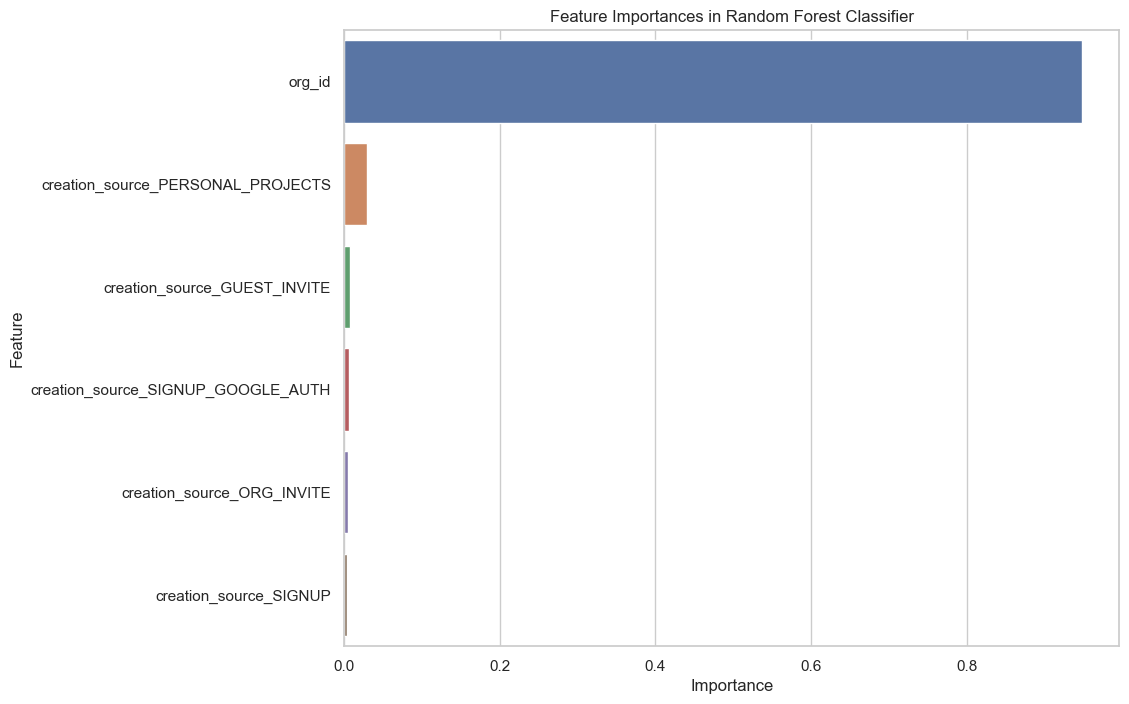

,Feature,Importance
5,org_id,0.948559
2,creation_source_PERSONAL_PROJECTS,0.029733
0,creation_source_GUEST_INVITE,0.006999
4,creation_source_SIGNUP_GOOGLE_AUTH,0.006725
1,creation_source_ORG_INVITE,0.004883
3,creation_source_SIGNUP,0.003101


In [25]:
# Get feature importances from the Random Forest model
feature_importances = rf_clf_upsampled.feature_importances_

# Create a DataFrame to display feature importances
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importances in Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Display the feature importances as a DataFrame
features_df

The refined analysis of the model indicates that the organization ID is the most predictive feature for identifying an adopted user, defined as someone who has logged into the product on three distinct days within any seven-day period.